In [1]:
from ipywidgets import FloatSlider
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import vae_model
import random
import scipy.misc

In [2]:
# Load VAE.
vae_model.reset_graph()
vae = vae_model.VariationalAutoencoder(z_size=64, batch_size=1, is_training=False)
#vae.load_json("vae.json")
vae.load_checkpoint("models")
print("Model loaded.")

INFO:tensorflow:Model using gpu.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
loading model models/vae-0
INFO:tensorflow:Loading model models/vae-0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vae-0
Model loaded.


In [3]:
import pickle

observations = pickle.load(open("vae_dataset-10000.p", "rb"))

In [4]:
# Parameters.
slider_min = -4.0
slider_max = 4.0
slider_step = 0.01

# Create latent space.
observation = random.choice(observations)
latent_vector = vae.encode(observation.reshape(1, 64, 64, 3))[0]
latent_space_size = len(latent_vector)
d = {}

# Create sliders.
for i in range(latent_space_size):
    value = latent_vector[i]
    slider = FloatSlider(min=slider_min, max=slider_max, step=slider_step, value=value)
    d["z"+str(i)] = slider

# Interactive function.
@interact(**d)
def function(**x):
    for key, value in x.items():
        index = int(key.replace("z", ""))
        latent_vector[index] = value
    #plt.plot(latent_vector)
    #plt.ylim((slider_min, slider_max))
    #plt.show()
    #plt.close()
    reconstruction = vae.decode(latent_vector.reshape((1, -1)))[0]
    plt.imshow(reconstruction)
    #print(np.min(decoded), np.max(decoded))

interactive(children=(FloatSlider(value=1.977325201034546, description='z0', max=4.0, min=-4.0, step=0.01), Fl…

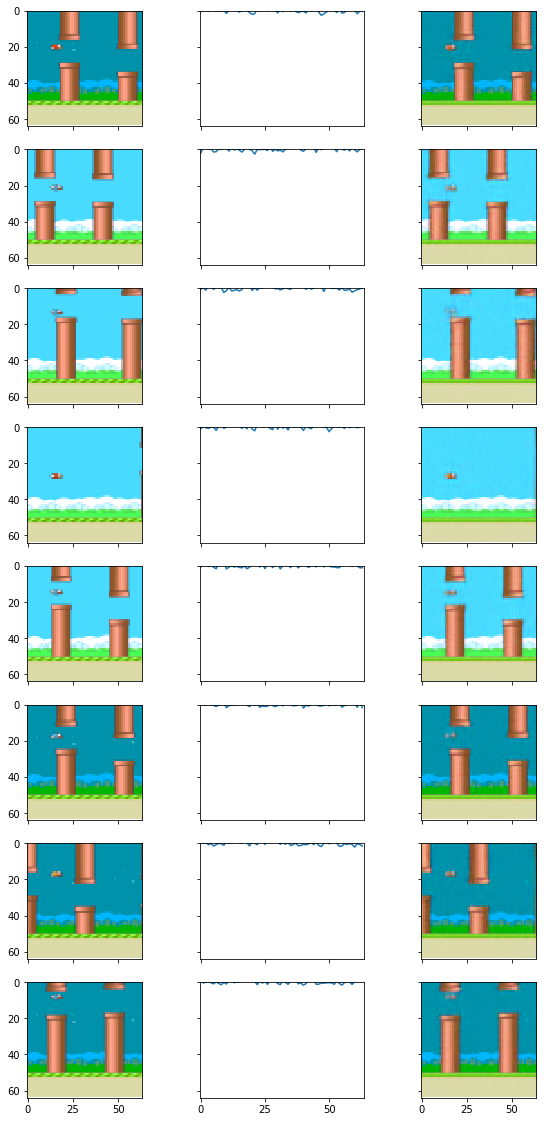

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

rows = 8
columns = 3

fig, axes = plt.subplots(rows, columns, figsize=(10, 20), sharex=True, sharey=True)

for row in range(rows):
    observation = random.choice(observations)
    axis = axes[row, 0]
    axis.set_ylim([64, 0])
    axis.imshow(observation)

    latent_vector = vae.encode(observation.reshape(1, 64, 64, 3))[0]
    axis = axes[row, 1]
    axis.set_ylim([10, 1])
    axis.plot(latent_vector)
    
    reconstruction = vae.reconstruct(observation.reshape(1, 64, 64, 3))[0]
    axis = axes[row, 2]
    axis.set_ylim([64, 0])
    axis.imshow(reconstruction)

plt.show()
plt.close()

In [6]:
from ipywidgets import Output
from IPython.display import clear_output

# The sliders.
widgets = {}

# Parameters.
slider_min = -4.0
slider_max = -slider_min
slider_step = 0.01

# Create latent space.
observation = random.choice(observations)
latent_vector = vae.encode(observation.reshape(1, 64, 64, 3))[0]
latent_space_size = len(latent_vector)

# Create sliders.
for i in range(latent_space_size):
    value = latent_vector[i]
    slider = FloatSlider(min=slider_min, max=slider_max, step=slider_step, value=value)
    widgets["z"+str(i)] = slider

# Create hboxes.
hboxes = []
columns = 4
for i in range(0, latent_space_size, columns):
    hbox = HBox([widgets["z" + str(j)] for j in range(i, i + columns) ])
    hboxes.append(hbox)

# Create user interface.
user_interface = VBox(hboxes)
display(user_interface)


def interact_hookup(f, controls):
    from ipywidgets import Output
    from IPython.display import clear_output
    out = Output()
    display(out)
    def observer(change):
        out.clear_output()
        kwargs = {k:v.value for k,v in controls.items()}
        with out:
            f(**kwargs)
    for k,w in controls.items():
        w.observe(observer, 'value')
    observer(None)

    
def render(**kwargs):
    for key, value in kwargs.items():
        index = int(key.replace("z", ""))
        latent_vector[index] = value
    reconstruction = vae.decode(latent_vector.reshape((1, -1)))[0]
    plt.imshow(reconstruction)
    plt.show()
    plt.close()
    
interact_hookup(render, widgets)



Output()

/Users/tristanbehrens/Development/python-venvs/venv-3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


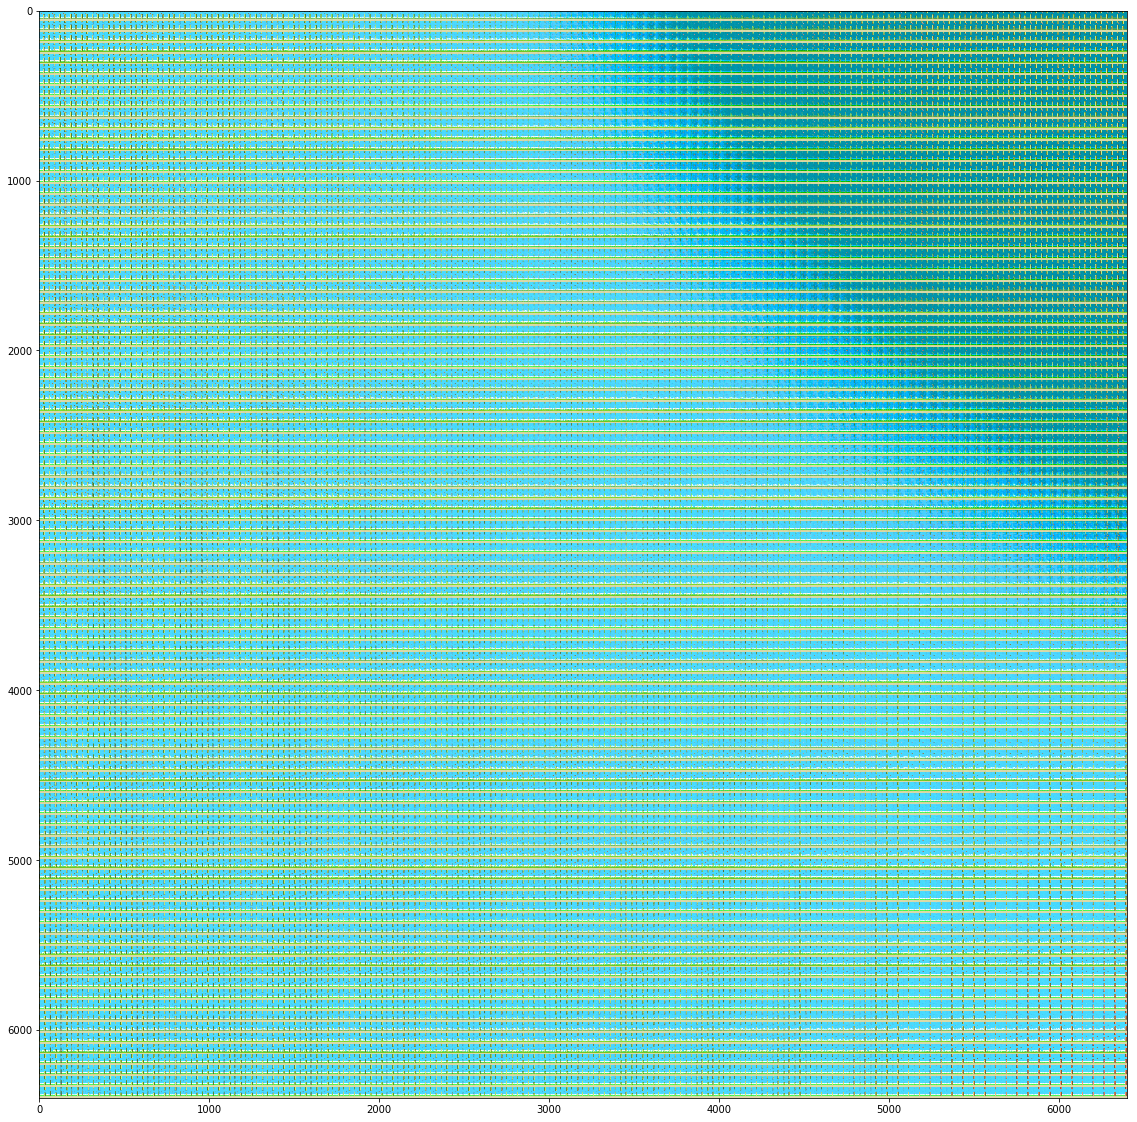

In [7]:
# Create latent space vectors.
latent_vectors = []
for _ in range(4):
    observation = random.choice(observations)
    latent_vector = vae.encode(observation.reshape(1, 64, 64, 3))[0]
    latent_vectors.append(latent_vector)
    
# Render rows and columns.    
rows = 100
columns = 100
row_images = []
for row in range(rows):
    column_images = []
    for column in range(columns):
        alpha = row / (rows - 1.0)
        beta = column / (columns - 1.0)
        
        # Interpolate.
        latent_vector_a = (1.0 - alpha) * latent_vectors[0] + alpha * latent_vectors[1]
        latent_vector_b = (1.0 - alpha) * latent_vectors[2] + alpha * latent_vectors[3]
        latent_vector_interpolated = (1.0 - beta) * latent_vector_a + beta * latent_vector_b
        
        #Reconstruct.
        reconstruction = vae.decode(latent_vector_interpolated.reshape((1, -1)))[0]
        column_images.append(reconstruction)
    column_images = np.vstack(column_images)
    row_images.append(column_images)
output_image = np.hstack(row_images)

# Plot.
plt.figure(figsize=(20,20))
plt.imshow(output_image)

# Write to file.
scipy.misc.imsave("interpolated-{}-{}.png".format(rows, columns), output_image)